# Goal
Credit One has seen an increase in customers who have defaulted on loans. If this continues, Credit One runs the risk of losing customers, therefor losing revenue. Our Data Science team has been tasked with designing and implementing a creative and empirically sound solution that will better detect the credit worthiness of a customer.

Breakdown total number of defaults by demographics and balances

# Initial Exploration Findings
30,000 observations

### Limit Balance (LIMIT_BAL)
Min: $10,000 Avg: $167,484.32 Max: $1,000,000.00

### Sex
Majority of individuals are female (18,112)
Males (11,888)
24% of males default
21% of females default

### Age
Average: 35.5
Range 21 - 79
21 - 29 9,618
30 - 39 11,238
40 - 49 6,464
50 - 59 2,341
60 - 69 341
70 - 79 25

### Marriage
9.2% of others default
23.4% of married people default
21% of single people default
26% of divorced people default - sample size is small though

### Default
Of the 30k accounts, on average, 22% defaulted 

# Questions
Since Education levels 1-3 have labels associated with them and 0, 4-6 do not. Can I combine 0, 4-6 into on aggregated column? 

When binning/discretizing how do you know when you have enough bins or too many?

Running: credit_data.groupby(['SEX', 'AGE RANGE', 'DEFAULT'])['DEFAULT'].count() gave me the desire output. Now I am stuck on how to visualize it. Do I need to save the output as a new dataframe and visualize that?


# Data Description
X1 **Limit_Bal** Amount of the given credit: it includes both the individual consumer credit and his/her family credit.  
X2 **Sex** 1 = male 2 = female  
X3 **Education** 1 = graduate school 2 = university 3 = high school [0, 4, 5, 6] = others  
X4 **Marital status** 1 = married 2 = single 3 = divorce 0=others  
X5: **Age** year  

#### History of past payment status (2005)
X6 - X11 September - April  
-2 = No consumption -1 = Paid in full 0 = Use of revolving credit [1:9] x = payment delay by x months


#### Amount of bill statement
X12 - X17 September - April

#### Amount of previous payment
X18 - X23 September - April

Y **Dependent variable** 0 = no default 1 = default

In [145]:
# import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy


from math import sqrt

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#cross validation
from sklearn.cross_validation import train_test_split


In [3]:
credit_data = pd.read_csv('default of credit card clients.csv', header =1)

# Custom Functions

In [4]:
# for a given set of columns in a df.describe() output average the given attribute
# Arguments
# df - data frame on which .describe() was run
# cols - array of columns to average
# attr - desired attribute in string
def col_descr_avg(df, cols, attr):
    total = 0
    for x in cols:
        total += df[x].describe()[attr]

    return total/len(cols)

In [5]:
# for a given set of columns in a df.describe() output the sum the given attribute
# Arguments
# df - data frame on which .describe() was run
# cols - array of columns to average
# attr - desired attribute in string
def col_descr_sum(df, cols, attr):
    total = 0
    for x in cols:
        total += df[x].describe()[attr]

    return total

In [6]:
def discretize(df, col_new, col_old, num):
    for x in range(1, num):
        new_col = col_new + " " + str(x) + " RANGE"
        old_col = col_old + str(x)
        df[new_col] = pd.cut(x=df[old_col], bins=[-1000000, 0, 125000, 250000, 375000, 500000, 625000, 750000, 875000, 2000000], labels=['0','1', '2', '3', '4', '5', '6', '7', '8'], right=False)
        print(new_col)

In [7]:
# rename 'default payment next month to DEFAULT to shorten the column name'
credit_data = credit_data.rename(columns = {"default payment next month":"DEFAULT"})

# remove ID column since it has nothing to do with the data
#credit_data.drop(['ID'], axis=1, inplace=True)
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
#discretize credit limit into 8 bins
credit_data['LIMIT RANGE'] = pd.cut(x=credit_data['LIMIT_BAL'], bins=[0, 125000, 250000, 375000, 500000, 625000, 750000, 875000, 1000000], labels=['1', '2', '3', '4', '5', '6', '7', '8'], right=True)

discretize(credit_data, "PAY AMT", "PAY_AMT", 7)
discretize(credit_data, "BILL AMT", "BILL_AMT", 7)

#discretize age into 6 bins
credit_data['AGE RANGE'] = pd.cut(x=credit_data['AGE'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['1', '2', '3', '4', '5', '6'], right=False)

PAY AMT 1 RANGE
PAY AMT 2 RANGE
PAY AMT 3 RANGE
PAY AMT 4 RANGE
PAY AMT 5 RANGE
PAY AMT 6 RANGE
BILL AMT 1 RANGE
BILL AMT 2 RANGE
BILL AMT 3 RANGE
BILL AMT 4 RANGE
BILL AMT 5 RANGE
BILL AMT 6 RANGE


# Global Variables

In [9]:
# Create a variable that holds the column names of the data
cols = list(credit_data.columns)
cols = ['LIMIT_BAL',
 'LIMIT RANGE',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'AGE RANGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL AMT 1 RANGE',
 'BILL_AMT2',
 'BILL AMT 2 RANGE',
 'BILL_AMT3',
 'BILL AMT 3 RANGE',
 'BILL_AMT4',
 'BILL AMT 4 RANGE',
 'BILL_AMT5',
 'BILL AMT 5 RANGE',
 'BILL_AMT6',
 'BILL AMT 6 RANGE',
 'PAY_AMT1',
 'PAY AMT 1 RANGE',
 'PAY_AMT2',
 'PAY AMT 2 RANGE',
 'PAY_AMT3',
 'PAY AMT 3 RANGE',
 'PAY_AMT4',
 'PAY AMT 4 RANGE',
 'PAY_AMT5',
 'PAY AMT 5 RANGE',
 'PAY_AMT6',
 'PAY AMT 6 RANGE',
 'DEFAULT']
credit_data = credit_data[cols]


In [60]:
credit_data['DEPVAR'] = pd.cut(x=credit_data['DEFAULT'], bins=[0, 1, 2], labels=['0','1'], right=False)

In [61]:
credit_data.head()

,LIMIT_BAL,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE,AGE RANGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL AMT 1 RANGE,BILL_AMT2,BILL AMT 2 RANGE,BILL_AMT3,BILL AMT 3 RANGE,BILL_AMT4,BILL AMT 4 RANGE,BILL_AMT5,BILL AMT 5 RANGE,BILL_AMT6,BILL AMT 6 RANGE,PAY_AMT1,PAY AMT 1 RANGE,PAY_AMT2,PAY AMT 2 RANGE,PAY_AMT3,PAY AMT 3 RANGE,PAY_AMT4,PAY AMT 4 RANGE,PAY_AMT5,PAY AMT 5 RANGE,PAY_AMT6,PAY AMT 6 RANGE,DEFAULT,DEPVAR
0,20000,1,2,2,1,24,1,2,2,-1,-1,-2,-2,3913,1,3102,1,689,1,0,1,0,1,0,1,0,1,689,1,0,1,0,1,0,1,0,1,1,1
1,120000,1,2,2,2,26,1,-1,2,0,0,0,2,2682,1,1725,1,2682,1,3272,1,3455,1,3261,1,0,1,1000,1,1000,1,1000,1,0,1,2000,1,1,1
2,90000,1,2,2,2,34,2,0,0,0,0,0,0,29239,1,14027,1,13559,1,14331,1,14948,1,15549,1,1518,1,1500,1,1000,1,1000,1,1000,1,5000,1,0,0
3,50000,1,2,2,1,37,2,0,0,0,0,0,0,46990,1,48233,1,49291,1,28314,1,28959,1,29547,1,2000,1,2019,1,1200,1,1100,1,1069,1,1000,1,0,0
4,50000,1,1,2,1,57,4,-1,0,-1,0,0,0,8617,1,5670,1,35835,1,20940,1,19146,1,19131,1,2000,1,36681,1,10000,1,9000,1,689,1,679,1,0,0


In [62]:
credit_data

,LIMIT_BAL,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE,AGE RANGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL AMT 1 RANGE,BILL_AMT2,BILL AMT 2 RANGE,BILL_AMT3,BILL AMT 3 RANGE,BILL_AMT4,BILL AMT 4 RANGE,BILL_AMT5,BILL AMT 5 RANGE,BILL_AMT6,BILL AMT 6 RANGE,PAY_AMT1,PAY AMT 1 RANGE,PAY_AMT2,PAY AMT 2 RANGE,PAY_AMT3,PAY AMT 3 RANGE,PAY_AMT4,PAY AMT 4 RANGE,PAY_AMT5,PAY AMT 5 RANGE,PAY_AMT6,PAY AMT 6 RANGE,DEFAULT,DEPVAR
0,20000,1,2,2,1,24,1,2,2,-1,-1,-2,-2,3913,1,3102,1,689,1,0,1,0,1,0,1,0,1,689,1,0,1,0,1,0,1,0,1,1,1
1,120000,1,2,2,2,26,1,-1,2,0,0,0,2,2682,1,1725,1,2682,1,3272,1,3455,1,3261,1,0,1,1000,1,1000,1,1000,1,0,1,2000,1,1,1
2,90000,1,2,2,2,34,2,0,0,0,0,0,0,29239,1,14027,1,13559,1,14331,1,14948,1,15549,1,1518,1,1500,1,1000,1,1000,1,1000,1,5000,1,0,0
3,50000,1,2,2,1,37,2,0,0,0,0,0,0,46990,1,48233,1,49291,1,28314,1,28959,1,29547,1,2000,1,2019,1,1200,1,1100,1,1069,1,1000,1,0,0
4,50000,1,1,2,1,57,4,-1,0,-1,0,0,0,8617,1,5670,1,35835,1,20940,1,19146,1,19131,1,2000,1,36681,1,10000,1,9000,1,689,1,679,1,0,0
5,50000,1,1,1,2,37,2,0,0,0,0,0,0,64400,1,57069,1,57608,1,19394,1,19619,1,20024,1,2500,1,1815,1,657,1,1000,1,1000,1,800,1,0,0
6,500000,4,1,1,2,29,1,0,0,0,0,0,0,367965,3,412023,4,445007,4,542653,5,483003,4,473944,4,55000,1,40000,1,38000,1,20239,1,13750,1,13770,1,0,0
7,100000,1,2,2,2,23,1,0,-1,-1,0,0,-1,11876,1,380,1,601,1,221,1,-159,0,567,1,380,1,601,1,0,1,581,1,1687,1,1542,1,0,0
8,140000,2,2,3,1,28,1,0,0,2,0,0,0,11285,1,14096,1,12108,1,12211,1,11793,1,3719,1,3329,1,0,1,432,1,1000,1,1000,1,1000,1,0,0
9,20000,1,1,3,2,35,2,-2,-2,-2,-2,-1,-1,0,1,0,1,0,1,0,1,13007,1,13912,1,0,1,0,1,0,1,13007,1,1122,1,0,1,0,0


In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
credit_data_model.iloc[67:69, :]
#credit_data_model.isnull()
#is_NaN = credit_data_model.isnull()
#row_has_NaN = is_NaN.any(axis=1)
#rows_with_NaN = credit_data[row_has_NaN]
#rows_with_NaN

NameError: name 'credit_data_model' is not defined

In [14]:
credit_data[["BILL_AMT1","BILL AMT 1 RANGE","BILL_AMT2", "BILL AMT 2 RANGE", "BILL_AMT3"]].iloc[67:69]

,BILL_AMT1,BILL AMT 1 RANGE,BILL_AMT2,BILL AMT 2 RANGE,BILL_AMT3
67,300,1,300,1,1159
68,-190,0,-9850,0,-9850


In [15]:
credit_data.iloc[28710:28720,27:29]

,PAY_AMT2,PAY AMT 2 RANGE
28710,1881,1
28711,0,1
28712,5800,1
28713,3700,1
28714,5991,1
28715,39558,1
28716,1215471,8
28717,3930,1
28718,291,1
28719,1393,1


In [16]:
credit_data['AGE RANGE'].describe()

count     30000
unique        6
top           2
freq      11238
Name: AGE RANGE, dtype: object

In [17]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 38 columns):
LIMIT_BAL           30000 non-null int64
LIMIT RANGE         30000 non-null category
SEX                 30000 non-null int64
EDUCATION           30000 non-null int64
MARRIAGE            30000 non-null int64
AGE                 30000 non-null int64
AGE RANGE           30000 non-null category
PAY_0               30000 non-null int64
PAY_2               30000 non-null int64
PAY_3               30000 non-null int64
PAY_4               30000 non-null int64
PAY_5               30000 non-null int64
PAY_6               30000 non-null int64
BILL_AMT1           30000 non-null int64
BILL AMT 1 RANGE    30000 non-null category
BILL_AMT2           30000 non-null int64
BILL AMT 2 RANGE    30000 non-null category
BILL_AMT3           30000 non-null int64
BILL AMT 3 RANGE    30000 non-null category
BILL_AMT4           30000 non-null int64
BILL AMT 4 RANGE    30000 non-null category
BILL_AMT5   

In [18]:
# nubmer of males
(credit_data.SEX == 1).sum()

11888

In [19]:
# nubmer of females
(credit_data.SEX == 2).sum()

18112

In [20]:
# leverage groupby to streamline counting
credit_data.groupby('SEX')['SEX'].count()

SEX
1    11888
2    18112
Name: SEX, dtype: int64

In [21]:
credit_data.groupby(['SEX', 'DEFAULT'])['DEFAULT'].count()

SEX  DEFAULT
1    0           9015
     1           2873
2    0          14349
     1           3763
Name: DEFAULT, dtype: int64

In [22]:
default_by_sex_by_bill_1 = credit_data.groupby(['SEX', 'BILL AMT 3 RANGE', 'DEFAULT'])['DEFAULT']
type(default_by_sex_by_bill_1)
default_by_sex_by_bill_1.describe()

count  mean  std  min  25%  50%  75%  max
SEX BILL AMT 3 RANGE DEFAULT                                             
1   0                0          236.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           56.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    1                0         7693.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1         2499.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    2                0          852.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1          242.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    3                0          164.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           57.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    4                0           64.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           18.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    5                0            4.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1            1.0   1.0  NaN  1.0  1.0  1.0  1.0  1.0
    6                0            2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0                0          290.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           73.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    1                0        12517.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1         3348.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    2                0         1247.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1          251.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    3                0          234.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           66.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    4                0           51.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1           19.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    5                0            6.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                     1            6.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    6                0            2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
    7                0            1.0   0.0  NaN  0.0  0.0  0.0  0.0  0.0
    8                0            1.0   0.0  NaN  0.0  0.0  0.0  0.0  0.0

In [23]:
default_by_sex_by_age = credit_data.groupby(['SEX', 'AGE RANGE', 'DEFAULT'])['DEFAULT']
type(default_by_sex_by_age)
default_by_sex_by_age.describe()

count  mean  std  min  25%  50%  75%  max
SEX AGE RANGE DEFAULT                                            
1   1         0        2492.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1         789.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    2         0        3515.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1        1050.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    3         0        2080.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1         691.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    4         0         797.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1         295.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    5         0         122.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1          44.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    6         0           9.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1           4.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2   1         0        4929.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1        1408.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    2         0        5447.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1        1226.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    3         0        2899.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1         794.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    4         0         962.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1         287.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    5         0         103.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1          45.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
    6         0           9.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              1           3.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [24]:
credit_data.groupby('MARRIAGE')['MARRIAGE'].count()

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [25]:
credit_data.groupby(['MARRIAGE', 'DEFAULT'])['DEFAULT'].count()

MARRIAGE  DEFAULT
0         0             49
          1              5
1         0          10453
          1           3206
2         0          12623
          1           3341
3         0            239
          1             84
Name: DEFAULT, dtype: int64

In [26]:
credit_data.groupby(['EDUCATION', 'DEFAULT'])['DEFAULT'].count()

EDUCATION  DEFAULT
0          0             14
1          0           8549
           1           2036
2          0          10700
           1           3330
3          0           3680
           1           1237
4          0            116
           1              7
5          0            262
           1             18
6          0             43
           1              8
Name: DEFAULT, dtype: int64

In [27]:
def my_find(x):
    if x == 1:
        return true
#print(my_find(credit_data, 'DEFAULT', 1))
#credit_data.query("DEFAULT == 1")
#credit_data.groupby(['SEX'])['DEFAULT'].query("DEFAULT == 1")['SEX'].sum()

credit_data.query("DEFAULT == 1").sum()
    
#credit_data.groupby(['SEX', 'EDUCATION'])['DEFAULT'].count()

LIMIT_BAL           8.634077e+08
LIMIT RANGE                  inf
SEX                 1.039900e+04
EDUCATION           1.257300e+04
MARRIAGE            1.014000e+04
AGE                 2.370760e+05
AGE RANGE                    inf
PAY_0               4.434000e+03
PAY_2               3.041000e+03
PAY_3               2.403000e+03
PAY_4               1.689000e+03
PAY_5               1.114000e+03
PAY_6               7.440000e+02
BILL_AMT1           3.219068e+08
BILL AMT 1 RANGE             inf
BILL_AMT2           3.137741e+08
BILL AMT 2 RANGE             inf
BILL_AMT3           2.998251e+08
BILL AMT 3 RANGE             inf
BILL_AMT4           2.789572e+08
BILL AMT 4 RANGE             inf
BILL_AMT5           2.623887e+08
BILL AMT 5 RANGE             inf
BILL_AMT6           2.539692e+08
BILL AMT 6 RANGE             inf
PAY_AMT1            2.254278e+07
PAY AMT 1 RANGE              inf
PAY_AMT2            2.248708e+07
PAY AMT 2 RANGE              inf
PAY_AMT3            2.234574e+07
PAY AMT 3 

In [28]:
credit_data.pivot_table(values='DEFAULT', index=['AGE RANGE'], columns=['SEX'], aggfunc=np.sum, margins=True)

SEX,1,2,All
AGE RANGE,,,
1,789,1408,2197
2,1050,1226,2276
4,691,794,1485
3,295,287,582
5,44,45,89
6,4,3,7
All,2873,3763,6636


In [29]:
credit_data.pivot_table('BILL_AMT1', 'SEX', 'MARRIAGE', aggfunc=np.sum, margins=True)

MARRIAGE,0,1,2,3,All
SEX,,,,,
1,315209,301673091,337699897,5604379,645292576
2,786424,425779694,456499760,8341473,891407351
All,1101633,727452785,794199657,13945852,1536699927


In [30]:
credit_data.pivot_table('BILL_AMT1', 'SEX', 'EDUCATION', aggfunc=np.mean, margins=True)

EDUCATION,0,1,2,3,4,5,6,All
SEX,,,,,,,,
1,11191.875000,56505.386082,53178.626907,50514.905528,68122.547619,89512.178947,60287.320000,54281.004038
2,12566.333333,43458.964051,53870.575439,45556.984626,47636.753086,77558.529730,103201.846154,49216.395263
All,11780.928571,48825.437506,53605.533999,47563.546065,54631.902439,81614.232143,82165.313725,51223.330900


High school educated demographic on average has the higher rate of defaults

In [31]:
credit_data.pivot_table('DEFAULT', 'SEX', 'EDUCATION', aggfunc=np.mean, margins=True)

EDUCATION,0,1,2,3,4,5,6,All
SEX,,,,,,,,
1,0.0,0.208085,0.262002,0.273869,0.095238,0.063158,0.160000,0.241672
2,0.0,0.181351,0.222043,0.236420,0.037037,0.064865,0.153846,0.207763
All,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863,0.221200


In [32]:
credit_data.pivot_table('DEFAULT', 'SEX', 'LIMIT_BAL', aggfunc=np.mean, margins=True)

LIMIT_BAL,10000,16000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,190000,200000,210000,220000,230000,240000,250000,260000,270000,280000,290000,300000,310000,320000,327680,330000,340000,350000,360000,370000,380000,390000,400000,410000,420000,430000,440000,450000,460000,470000,480000,490000,500000,510000,520000,530000,540000,550000,560000,570000,580000,590000,600000,610000,620000,630000,640000,650000,660000,670000,680000,690000,700000,710000,720000,730000,740000,750000,760000,780000,800000,1000000,All
SEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.392157,0.0,0.359459,0.365936,0.367816,0.259828,0.290657,0.305556,0.242366,0.289474,0.302387,0.245455,0.309623,0.230496,0.271375,0.189974,0.232932,0.158974,0.203077,0.288660,0.222031,0.200000,0.198925,0.146789,0.158798,0.192308,0.172973,0.170732,0.150259,0.170732,0.197861,0.107527,0.129771,1.0,0.104478,0.242424,0.125000,0.156250,0.193548,0.160494,0.092308,0.110000,0.175000,0.085714,0.103448,0.222222,0.214286,0.146341,0.116279,0.027778,0.210526,0.121212,0.200000,0.111111,0.0,0.0,0.300000,0.00,0.0,0.000000,0.000000,0.5000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,NaN,0.0,0.000000,1.000000,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.241672
2,0.411765,0.0,0.345266,0.345133,0.419580,0.265976,0.277985,0.277662,0.226270,0.240781,0.235469,0.211957,0.215606,0.205817,0.202083,0.157319,0.177528,0.139466,0.164179,0.159091,0.148891,0.142000,0.183746,0.156069,0.189119,0.118182,0.163690,0.089744,0.133333,0.142222,0.158038,0.094972,0.149171,NaN,0.132075,0.105960,0.148148,0.189135,0.050000,0.093333,0.110092,0.116959,0.131579,0.122449,0.129630,0.107143,0.120879,0.102564,0.162162,0.116279,0.000000,0.104592,0.071429,0.090909,0.2,0.0,0.272727,0.25,0.0,0.200000,0.333333,0.0000,0.0,0.200000,0.250000,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.333333,0.000000,NaN,1.0,0.0,NaN,0.0,NaN,0.0,0.207763
All,0.399594,0.0,0.353239,0.352795,0.400000,0.263001,0.282424,0.287278,0.231653,0.254992,0.259542,0.224490,0.246556,0.215364,0.226969,0.168468,0.197406,0.146617,0.176884,0.213974,0.176702,0.160274,0.189765,0.153324,0.177706,0.145714,0.166987,0.117647,0.139959,0.152299,0.171480,0.099265,0.141026,1.0,0.121387,0.147465,0.138528,0.174801,0.112676,0.128205,0.103448,0.114391,0.153846,0.107143,0.120482,0.144578,0.161491,0.125000,0.137500,0.075949,0.125000,0.112188,0.105263,0.100000,0.1,0.0,0.285714,0.10,0.0,0.090909,0.166667,0.1875,0.0,0.111111,0.142857,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.166667,0.333333,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.221200


Discretize the age by 10 year segments

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


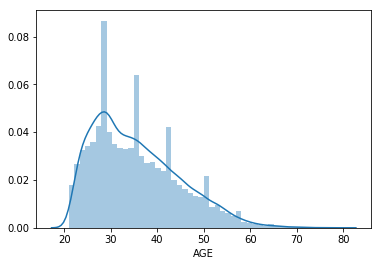

In [33]:
sns.distplot(credit_data['AGE'])

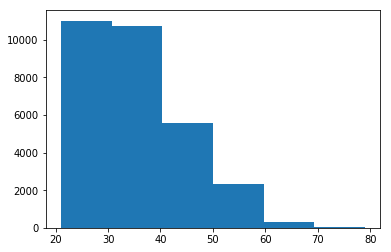

In [34]:
plt.hist(credit_data['AGE'], bins=6, label="AGE")
plt.show()

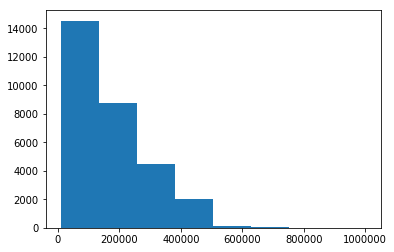

In [35]:
plt.hist(credit_data['LIMIT_BAL'], bins=8)
plt.show()

In [36]:
# nubmer of 21 - 29 year olds
((credit_data.AGE >= 21) & (credit_data.AGE < 30)).sum()

9618

In [37]:
# nubmer of 30 - 39 year olds
((credit_data.AGE >= 30) & (credit_data.AGE < 40)).sum()

11238

In [38]:
# nubmer of 40 - 49 year olds
((credit_data.AGE >= 40) & (credit_data.AGE < 50)).sum()

6464

In [39]:
# nubmer of 50 - 59 year olds
((credit_data.AGE >= 50) & (credit_data.AGE < 60)).sum()

2341

In [40]:
# nubmer of 60 - 69 year olds
((credit_data.AGE >= 60) & (credit_data.AGE < 70)).sum()

314

In [41]:
# nubmer of 70 - 79 year olds
((credit_data.AGE >= 70) & (credit_data.AGE < 80)).sum()

25

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


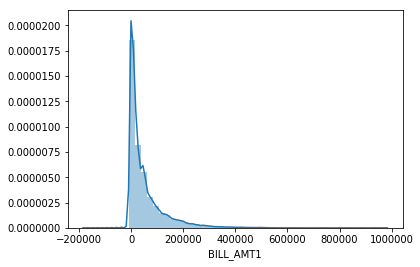

In [42]:
sns.distplot(credit_data['BILL_AMT1'])

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


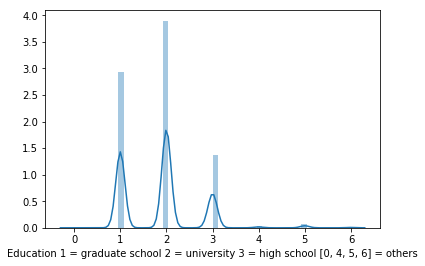

In [43]:
sns.distplot(credit_data['EDUCATION'], axlabel="Education 1 = graduate school 2 = university 3 = high school [0, 4, 5, 6] = others")

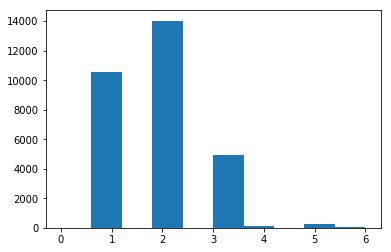

In [44]:
plt.hist(credit_data['EDUCATION'])
plt.show()

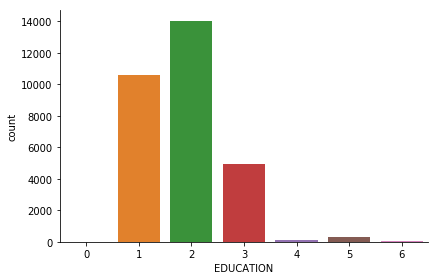

In [45]:
fg = sns.factorplot('EDUCATION', data=credit_data, kind='count', aspect=1.5)
fg.set_xlabels('EDUCATION')

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


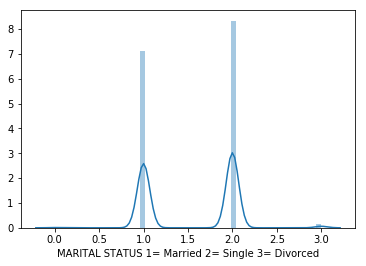

In [46]:
sns.distplot(credit_data['MARRIAGE'], axlabel="MARITAL STATUS 1= Married 2= Single 3= Divorced")

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


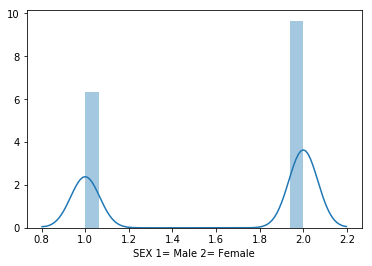

In [47]:
sns.distplot(credit_data['SEX'], axlabel="SEX 1= Male 2= Female")

/Users/thompsoj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


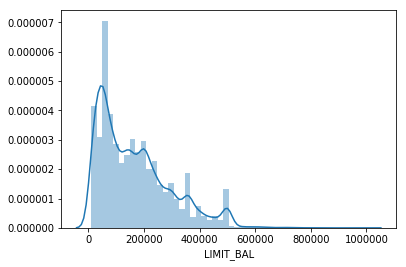

In [48]:
sns.distplot(credit_data['LIMIT_BAL'])

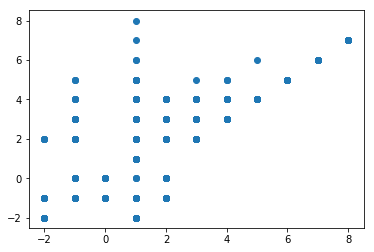

In [49]:
x = credit_data['PAY_0']
y = credit_data['PAY_2']
plt.scatter(x,y)
plt.show()

Index(['LIMIT_BAL', 'LIMIT RANGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'AGE RANGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL AMT 1 RANGE', 'BILL_AMT2', 'BILL AMT 2 RANGE',
       'BILL_AMT3', 'BILL AMT 3 RANGE', 'BILL_AMT4', 'BILL AMT 4 RANGE',
       'BILL_AMT5', 'BILL AMT 5 RANGE', 'BILL_AMT6', 'BILL AMT 6 RANGE',
       'PAY_AMT1', 'PAY AMT 1 RANGE', 'PAY_AMT2', 'PAY AMT 2 RANGE',
       'PAY_AMT3', 'PAY AMT 3 RANGE', 'PAY_AMT4', 'PAY AMT 4 RANGE',
       'PAY_AMT5', 'PAY AMT 5 RANGE', 'PAY_AMT6', 'PAY AMT 6 RANGE',
       'DEFAULT'],
      dtype='object')


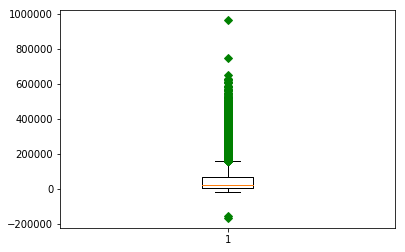

In [50]:
header = credit_data.dtypes.index
print(header)

A = credit_data['BILL_AMT1']
plt.boxplot(A,0,'gD')
plt.show()


In [51]:
corrMat = credit_data.corr()
print(corrMat)

           LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_0  \
LIMIT_BAL   1.000000  0.024755  -0.219161 -0.108139  0.144713 -0.271214   
SEX         0.024755  1.000000   0.014232 -0.031389 -0.090874 -0.057643   
EDUCATION  -0.219161  0.014232   1.000000 -0.143464  0.175061  0.105364   
MARRIAGE   -0.108139 -0.031389  -0.143464  1.000000 -0.414170  0.019917   
AGE         0.144713 -0.090874   0.175061 -0.414170  1.000000 -0.039447   
PAY_0      -0.271214 -0.057643   0.105364  0.019917 -0.039447  1.000000   
PAY_2      -0.296382 -0.070771   0.121566  0.024199 -0.050148  0.672164   
PAY_3      -0.286123 -0.066096   0.114025  0.032688 -0.053048  0.574245   
PAY_4      -0.267460 -0.060173   0.108793  0.033122 -0.049722  0.538841   
PAY_5      -0.249411 -0.055064   0.097520  0.035629 -0.053826  0.509426   
PAY_6      -0.235195 -0.044008   0.082316  0.034345 -0.048773  0.474553   
BILL_AMT1   0.285430 -0.033642   0.023581 -0.023472  0.056239  0.187068   
BILL_AMT2   0.278314 -0.0

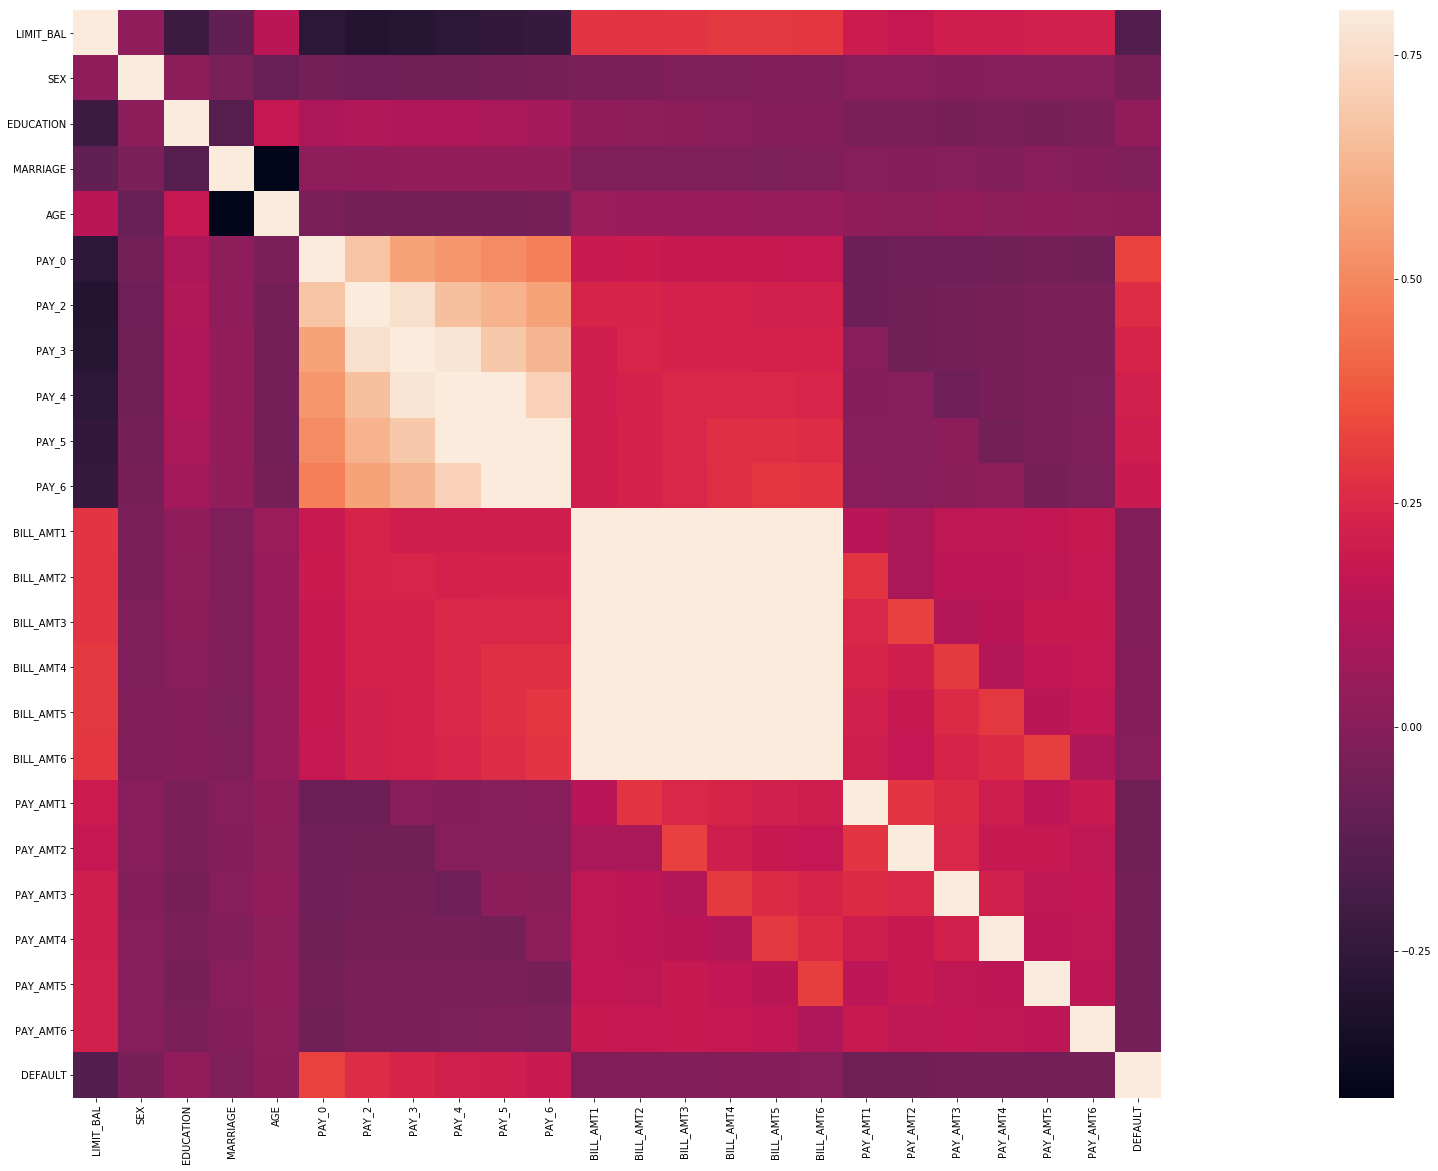

In [52]:
corrmat = credit_data.corr()
f, ax = plt.subplots(figsize=(64, 20))
sns.heatmap(corrmat, vmax=.8, square=True);

In [53]:
k = 25 #number of variables for heatmap
corr_cols = corrmat.nlargest(k, 'DEFAULT')['DEFAULT'].index
cm = np.corrcoef(credit_data[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (64,20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

There is no missing data in this dataset

In [54]:
# covariance
covMat = credit_data.cov()
print(covMat)

              LIMIT_BAL          SEX     EDUCATION     MARRIAGE  \
LIMIT_BAL  1.683446e+10  1571.050630 -22474.028945 -7323.669658   
SEX        1.571051e+03     0.239247      0.005502    -0.008014   
EDUCATION -2.247403e+04     0.005502      0.624651    -0.059184   
MARRIAGE  -7.323670e+03    -0.008014     -0.059184     0.272452   
AGE        1.730767e+05    -0.409726      1.275380    -1.992764   
PAY_0     -3.954593e+04    -0.031685      0.093584     0.011683   
PAY_2     -4.603765e+04    -0.041442      0.115025     0.015122   
PAY_3     -4.443225e+04    -0.038694      0.107861     0.020421   
PAY_4     -4.057181e+04    -0.034411      0.100528     0.020213   
PAY_5     -3.667056e+04    -0.030521      0.087340     0.021074   
PAY_6     -3.509308e+04    -0.024754      0.074816     0.020616   
BILL_AMT1  2.727020e+09 -1211.694332   1372.377644  -902.154685   
BILL_AMT2  2.570130e+09 -1085.595467   1054.657595  -802.517866   
BILL_AMT3  2.548533e+09  -833.207432    712.664124  -901.67908

In [55]:
#missing data
total = credit_data.isnull().sum().sort_values(ascending=False)
percent = (credit_data.isnull().sum()/credit_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
DEFAULT,0,0.0
PAY_3,0,0.0
BILL AMT 2 RANGE,0,0.0
BILL_AMT2,0,0.0
BILL AMT 1 RANGE,0,0.0
BILL_AMT1,0,0.0
PAY_6,0,0.0
PAY_5,0,0.0
PAY_4,0,0.0
PAY_2,0,0.0


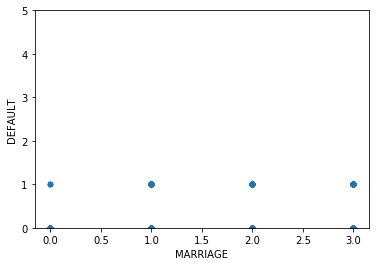

In [56]:
data = pd.concat([credit_data['DEFAULT'], credit_data[cols[4]]], axis=1)
data.plot.scatter(x=cols[4], y='DEFAULT', ylim=(0,5));

# Appendix

This is how you count specific instances

In [57]:
credit_data[credit_data['AGE'] < 30].count()


LIMIT_BAL           9618
LIMIT RANGE         9618
SEX                 9618
EDUCATION           9618
MARRIAGE            9618
AGE                 9618
AGE RANGE           9618
PAY_0               9618
PAY_2               9618
PAY_3               9618
PAY_4               9618
PAY_5               9618
PAY_6               9618
BILL_AMT1           9618
BILL AMT 1 RANGE    9618
BILL_AMT2           9618
BILL AMT 2 RANGE    9618
BILL_AMT3           9618
BILL AMT 3 RANGE    9618
BILL_AMT4           9618
BILL AMT 4 RANGE    9618
BILL_AMT5           9618
BILL AMT 5 RANGE    9618
BILL_AMT6           9618
BILL AMT 6 RANGE    9618
PAY_AMT1            9618
PAY AMT 1 RANGE     9618
PAY_AMT2            9618
PAY AMT 2 RANGE     9618
PAY_AMT3            9618
PAY AMT 3 RANGE     9618
PAY_AMT4            9618
PAY AMT 4 RANGE     9618
PAY_AMT5            9618
PAY AMT 5 RANGE     9618
PAY_AMT6            9618
PAY AMT 6 RANGE     9618
DEFAULT             9618
dtype: int64

In [58]:
# adding this above the correlation matrix controled the size
plt.figure(figsize = (64,20))

# remove column from data frame
df.drop(['column name'], axis=1, inplace=True)

NameError: name 'df' is not defined

<Figure size 4608x1440 with 0 Axes>

# Model Building

In [63]:
credit_data

,LIMIT_BAL,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE,AGE RANGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL AMT 1 RANGE,BILL_AMT2,BILL AMT 2 RANGE,BILL_AMT3,BILL AMT 3 RANGE,BILL_AMT4,BILL AMT 4 RANGE,BILL_AMT5,BILL AMT 5 RANGE,BILL_AMT6,BILL AMT 6 RANGE,PAY_AMT1,PAY AMT 1 RANGE,PAY_AMT2,PAY AMT 2 RANGE,PAY_AMT3,PAY AMT 3 RANGE,PAY_AMT4,PAY AMT 4 RANGE,PAY_AMT5,PAY AMT 5 RANGE,PAY_AMT6,PAY AMT 6 RANGE,DEFAULT,DEPVAR
0,20000,1,2,2,1,24,1,2,2,-1,-1,-2,-2,3913,1,3102,1,689,1,0,1,0,1,0,1,0,1,689,1,0,1,0,1,0,1,0,1,1,1
1,120000,1,2,2,2,26,1,-1,2,0,0,0,2,2682,1,1725,1,2682,1,3272,1,3455,1,3261,1,0,1,1000,1,1000,1,1000,1,0,1,2000,1,1,1
2,90000,1,2,2,2,34,2,0,0,0,0,0,0,29239,1,14027,1,13559,1,14331,1,14948,1,15549,1,1518,1,1500,1,1000,1,1000,1,1000,1,5000,1,0,0
3,50000,1,2,2,1,37,2,0,0,0,0,0,0,46990,1,48233,1,49291,1,28314,1,28959,1,29547,1,2000,1,2019,1,1200,1,1100,1,1069,1,1000,1,0,0
4,50000,1,1,2,1,57,4,-1,0,-1,0,0,0,8617,1,5670,1,35835,1,20940,1,19146,1,19131,1,2000,1,36681,1,10000,1,9000,1,689,1,679,1,0,0
5,50000,1,1,1,2,37,2,0,0,0,0,0,0,64400,1,57069,1,57608,1,19394,1,19619,1,20024,1,2500,1,1815,1,657,1,1000,1,1000,1,800,1,0,0
6,500000,4,1,1,2,29,1,0,0,0,0,0,0,367965,3,412023,4,445007,4,542653,5,483003,4,473944,4,55000,1,40000,1,38000,1,20239,1,13750,1,13770,1,0,0
7,100000,1,2,2,2,23,1,0,-1,-1,0,0,-1,11876,1,380,1,601,1,221,1,-159,0,567,1,380,1,601,1,0,1,581,1,1687,1,1542,1,0,0
8,140000,2,2,3,1,28,1,0,0,2,0,0,0,11285,1,14096,1,12108,1,12211,1,11793,1,3719,1,3329,1,0,1,432,1,1000,1,1000,1,1000,1,0,0
9,20000,1,1,3,2,35,2,-2,-2,-2,-2,-1,-1,0,1,0,1,0,1,0,1,13007,1,13912,1,0,1,0,1,0,1,13007,1,1122,1,0,1,0,0


In [109]:
#capture the columns that will be used for a new dataset
prediction_cols = ['LIMIT RANGE',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE RANGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL AMT 1 RANGE',
 'BILL AMT 2 RANGE',
 'BILL AMT 3 RANGE',
 'BILL AMT 4 RANGE',
 'BILL AMT 5 RANGE',
 'BILL AMT 6 RANGE',
 'PAY AMT 1 RANGE',
 'PAY AMT 2 RANGE',
 'PAY AMT 3 RANGE',
 'PAY AMT 4 RANGE',
 'PAY AMT 5 RANGE',
 'PAY AMT 6 RANGE',
 'DEPVAR']

In [132]:
pred_data = credit_data

In [133]:
pred_data[["LIMIT RANGE", "AGE RANGE", 'BILL AMT 1 RANGE','BILL AMT 2 RANGE','BILL AMT 3 RANGE','BILL AMT 4 RANGE','BILL AMT 5 RANGE','BILL AMT 6 RANGE','PAY AMT 1 RANGE','PAY AMT 2 RANGE','PAY AMT 3 RANGE','PAY AMT 4 RANGE','PAY AMT 5 RANGE','PAY AMT 6 RANGE']] = pred_data[["LIMIT RANGE", "AGE RANGE", 'BILL AMT 1 RANGE','BILL AMT 2 RANGE','BILL AMT 3 RANGE','BILL AMT 4 RANGE','BILL AMT 5 RANGE','BILL AMT 6 RANGE','PAY AMT 1 RANGE','PAY AMT 2 RANGE','PAY AMT 3 RANGE','PAY AMT 4 RANGE','PAY AMT 5 RANGE','PAY AMT 6 RANGE']].apply(pd.to_numeric)

In [134]:
feature_cols = ['LIMIT RANGE',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE RANGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL AMT 1 RANGE',
 'BILL AMT 2 RANGE',
 'BILL AMT 3 RANGE',
 'BILL AMT 4 RANGE',
 'BILL AMT 5 RANGE',
 'BILL AMT 6 RANGE',
 'PAY AMT 1 RANGE',
 'PAY AMT 2 RANGE',
 'PAY AMT 3 RANGE',
 'PAY AMT 4 RANGE',
 'PAY AMT 5 RANGE',
 'PAY AMT 6 RANGE']

feature_cols = ['LIMIT RANGE',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE RANGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']



features = pred_data[feature_cols]
depVar = pred_data['DEPVAR']
X_train = features[: 30000]
X_train.head()

,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE RANGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,2,2,1,1,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,1,2,2,2,1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,1,2,2,2,2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,1,2,2,1,2,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,1,1,2,1,4,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [135]:
y_train = depVar[: 30000]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 30000


0    1
1    1
2    0
3    0
4    0
Name: DEPVAR, dtype: category
Categories (2, object): [0 < 1]

In [114]:
demo_features_cols = ['LIMIT RANGE',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE RANGE']
demo_features = pred_data[demo_features_cols]
demo_depVar = pred_data['DEPVAR']
demo_X_train = demo_features[: 30000]
demo_X_train.head()

,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE RANGE
0,1,2,2,1,1
1,1,2,2,2,1
2,1,2,2,2,2
3,1,2,2,1,2
4,1,1,2,1,4


In [115]:
demo_y_train = depVar[: 30000]
demo_y_train_count = len(demo_y_train.index)
print('The number of observations in the Y training set are:',str(demo_y_train_count))
demo_y_train.head()

The number of observations in the Y training set are: 30000


0    1
1    1
2    0
3    0
4    0
Name: DEPVAR, dtype: category
Categories (2, object): [0 < 1]

In [136]:
#full prediction data set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
X_train.shape, X_test.shape

((22500, 23), (7500, 23))

In [118]:
#demographic data set
demo_X_train, demo_X_test, demo_y_train, demo_y_test = train_test_split(demo_X_train, demo_y_train)
demo_X_train.shape, demo_X_test.shape

((22500, 5), (7500, 5))

In [119]:
demo_features.head()

,LIMIT RANGE,SEX,EDUCATION,MARRIAGE,AGE RANGE
0,1,2,2,1,1
1,1,2,2,2,1
2,1,2,2,2,2
3,1,2,2,1,2
4,1,1,2,1,4


((22500, 17), (7500, 17))

In [137]:
modelRF = RandomForestRegressor(n_estimators=100, random_state=0)
modelRF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [138]:
modelRF.score(X_train,y_train)

0.8669584121497818

In [139]:
modelKNN = KNeighborsClassifier(n_neighbors=5)
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [140]:
modelKNN.score(X_train,y_train)

0.8175555555555556

In [146]:
modelSVC = SVC(kernel='linear')
modelSVC.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [148]:
modelSVC.score(X_train,y_train)

0.7648444444444444

In [122]:
demo_modelRF = RandomForestRegressor(n_estimators=20, random_state=0)
demo_modelRF.fit(demo_X_train, demo_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [124]:
demo_modelRF.score(demo_X_train,demo_y_train)

0.04669182967956542

In [152]:
predictions = modelRF.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.171
RMSE: 0.375


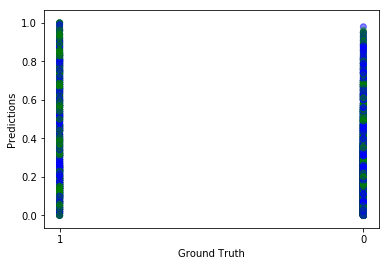

In [153]:
plt.scatter(y_test, predictions, color=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

In [154]:
predictions

array([0.23, 0.01, 0.  , ..., 0.15, 0.03, 0.2 ])

In [155]:
y_test

29169    1
22875    0
9966     0
13159    1
12056    0
24883    0
17481    0
4346     0
13078    0
23854    0
28905    0
20447    0
15224    0
10358    0
1995     0
3537     1
6648     0
29270    1
27356    0
28285    1
25566    0
21095    0
11623    0
26191    0
7224     0
25432    0
25961    0
6180     1
19582    0
19314    0
25708    0
2073     0
2388     0
29329    1
17740    0
18927    1
3058     0
20770    1
21914    0
21652    0
7493     0
15445    0
363      1
608      0
18316    1
19557    0
3964     0
181      0
18996    0
15825    0
12647    0
9603     0
12339    0
13625    0
28345    0
5695     0
5645     1
14125    0
23042    0
27210    0
26784    1
3738     1
26857    0
20607    0
4304     0
17078    0
27425    1
13912    0
25315    0
26533    1
16358    0
26933    0
6311     0
14120    0
18021    0
        ..
20507    0
5284     1
13189    0
26031    0
12393    0
20553    0
13372    0
4226     1
23480    0
26591    0
12876    1
8426     0
28166    1
25759    0
2908     1

# Deploy
Import pickle
import json
import requests

pickle.dump(modelName, open("modelName.pkl", "wb"))